# ATAC-seq - Aggregate and plot enrichment analysis results
- goal: summarize and plot enrichment results
- input: enrichment results from genomic region enrichment workflow
- output: summary tables/files & plots

In [1]:
cd ../

/home/sreichl/projects/bmdm-stim


In [2]:
# libraries
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pathlib

In [12]:
# configs
dir_data = os.path.join('results','ATAC','all')

LOLA_databases = ["LOLACore"]

LOLACore_sub_databases = ['encodeTFBSmm10','codex']#[]

GREAT_databases = ["GO Biological Process"]

GSEApy_databases = ["ENCODE_TF_ChIP-seq_2015", # TF
                    "ChEA_2016", # TF
                    "BioPlanet_2019",
                    "KEGG_2019_Mouse",
                    "WikiPathways_2019_Mouse",
                    "GO_Biological_Process_2021"
                   ]

databases = LOLA_databases + GREAT_databases + GSEApy_databases + LOLACore_sub_databases

# more stringent adj.p-value cut-off
databases_strict=[]#"BioPlanet_2019",
                  #"GO_Biological_Process_2021",
                 #]

In [45]:
def summarize_enrichment(region_list_names, data_dir, result_dir, top_n=5):
    
    # load all results into one dictionary
    res = dict()

    for db in databases:
        res[db]=dict()
        for region_list in region_list_names:

            if (db in LOLA_databases) and os.path.isfile(os.path.join(data_dir, region_list, 'LOLA', db, 'allEnrichments.tsv')):
                res[db][region_list]=pd.read_csv(os.path.join(data_dir, region_list, 'LOLA', db, 'allEnrichments.tsv'), sep='\t')
                res[db][region_list]['description']=res[db][region_list]['description'].astype(str)+' | '+res[db][region_list]['cellType'].astype(str)+' | '+res[db][region_list]['antibody'].astype(str)+' | '+res[db][region_list]['dataSource'].astype(str)+' | '+res[db][region_list]['filename'].astype(str)

            if (db in LOLACore_sub_databases) and os.path.isfile(os.path.join(data_dir, region_list, 'LOLA', 'LOLACore', 'col_{}.tsv'.format(db))):
                res[db][region_list]=pd.read_csv(os.path.join(data_dir, region_list, 'LOLA', 'LOLACore', 'col_{}.tsv'.format(db)), sep='\t')
                res[db][region_list]['description']=res[db][region_list]['description'].astype(str)+' | '+res[db][region_list]['cellType'].astype(str)+' | '+res[db][region_list]['antibody'].astype(str)+' | '+res[db][region_list]['dataSource'].astype(str)+' | '+res[db][region_list]['filename'].astype(str)
  
            if (db in GREAT_databases) and os.path.isfile(os.path.join(data_dir, region_list, 'GREAT', 'GREAT_{}.tsv'.format(db))):
                res[db][region_list]=pd.read_csv(os.path.join(data_dir, region_list, 'GREAT', 'GREAT_{}.tsv'.format(db)), sep='\t')
                res[db][region_list]['name']=res[db][region_list]['name']+res[db][region_list]['ID']

            if (db in GSEApy_databases) and os.path.isfile(os.path.join(data_dir, region_list, 'GSEApy', db, 'Enrichr_{}.csv'.format(db))):
                res[db][region_list]=pd.read_csv(os.path.join(data_dir, region_list, 'GSEApy', db, 'Enrichr_{}.csv'.format(db)))

    print(res.keys())

    # get all enrichment terms that are stat. significant in at least one gene list per database  and top_n for plotting
    sig_terms = dict()
    plot_terms = dict()

    for db in res.keys():
        sig_terms[db]=list()
        plot_terms[db]=list()
        
        for region_list in res[db].keys():

            if (db in LOLA_databases) or (db in LOLACore_sub_databases):
                term_col='description'
                adj_pvalue_col='qValue'
            if db in GREAT_databases:
                term_col='name'
                adj_pvalue_col='Hyper_Adjp_BH'
            if db in GSEApy_databases:
                term_col='Term'
                adj_pvalue_col='Adjusted P-value'

            if db in databases_strict:
                pvalue_cutoff = adj_pvalue_strict
            else:
                pvalue_cutoff = adj_pvalue

            tmp_sig_terms = res[db][region_list].loc[res[db][region_list][adj_pvalue_col]<pvalue_cutoff, term_col].to_list()
            sig_terms[db]=sig_terms[db]+tmp_sig_terms
        
            if len(tmp_sig_terms)>0:
                # select only top_n stat. sign. terms for plotting
                tmp_plot_terms = res[db][region_list].loc[[x in tmp_sig_terms for x in res[db][region_list][term_col]],:].sort_values(adj_pvalue_col).loc[:,term_col].to_list()
                plot_terms[db]=plot_terms[db] + tmp_plot_terms[:min(top_n,len(tmp_plot_terms))]

        sig_terms[db]=list(set(sig_terms[db]))
        plot_terms[db]=list(set(plot_terms[db]))
        print("{} {}".format(db, len(sig_terms[db])))

    # make summary data frames
    adj_pval=dict()
    overlap=dict()
    odds_ratio=dict()

    for db in res.keys():
        # make empty summary data frames for saving and plotting
        adj_pval[db]=pd.DataFrame(index=sig_terms[db], columns=region_list_names)
        overlap[db]=pd.DataFrame(index=sig_terms[db], columns=region_list_names)
        odds_ratio[db]=pd.DataFrame(index=sig_terms[db], columns=region_list_names)

        for region_list in res[db].keys():

            if (db in LOLA_databases) or (db in LOLACore_sub_databases):
                term_col='description'
                adj_pvalue_col='qValue'
                odds_ratio_col='oddsRatio'
                overlap_col='support'
            if db in GREAT_databases:
                term_col='name'
                adj_pvalue_col='Hyper_Adjp_BH'
                odds_ratio_col='Hyper_Fold_Enrichment'
                overlap_col='Hyper_Region_Set_Coverage'
            if db in GSEApy_databases:
                term_col='Term'
                adj_pvalue_col='Adjusted P-value'
                odds_ratio_col='Odds Ratio'
                overlap_col='Overlap'

            # determine sig. terms within the result
            idx_intersect = list(set(res[db][region_list].set_index(term_col).index).intersection(set(sig_terms[db])))

            # fill data frames
            adj_pval[db].loc[idx_intersect,region_list]=res[db][region_list].set_index(term_col).loc[idx_intersect, adj_pvalue_col]
            overlap[db].loc[idx_intersect,region_list]=res[db][region_list].set_index(term_col).loc[idx_intersect,overlap_col]
            odds_ratio[db].loc[idx_intersect,region_list]=res[db][region_list].set_index(term_col).loc[idx_intersect, odds_ratio_col]

    if not os.path.exists(os.path.join(result_dir,"0_summaries")):
        pathlib.Path(os.path.join(result_dir,"0_summaries")).mkdir(parents=True, exist_ok=True)

    # save summary data frames
    for db in res.keys():
        adj_pval[db].to_csv(os.path.join(result_dir, "0_summaries","summary_{}_adjpvalues.csv".format(db)))

        if db in GSEApy_databases:
            # convert overlaps from string to proportion by evaluation
            overlap[db][overlap[db].isna()]='0'
            overlap[db].applymap(eval).to_csv(os.path.join(result_dir, "0_summaries","summary_{}_overlap.csv".format(db)))
        else:
            overlap[db].to_csv(os.path.join(result_dir, "0_summaries","summary_{}_overlap.csv".format(db)))

        odds_ratio[db].to_csv(os.path.join(result_dir, "0_summaries","summary_{}_oddsratio.csv".format(db)))

    # plot selected top_n Terms per gene_list from summary data frames as clustermaps

    for db in res.keys():
            
        # determine number of non-empty gene_list results ie columns
        region_lists_n = sum((adj_pval[db].loc[plot_terms[db],:].notna()).any(axis=0))
#         print(region_lists_n)
        
        if (adj_pval[db].shape[0]<2) or (region_lists_n<2):
            continue
        
        # clustermap parameters
#         width = round(len(gene_lists.keys())/4)
        width = round(region_lists_n/3)
        height = round(len(plot_terms[db])/4)
        dendrogram_ratio = 0.01
        cbar_pos=(0.02, 0.98, 0.01, 0.05)

        ### adjusted p value
        # transform adj_pvalues for plotting
        mask = adj_pval[db].loc[plot_terms[db],:].isna()
        adj_pval_plot = -1*np.log10(adj_pval[db].loc[plot_terms[db],:].apply(pd.to_numeric))
        adj_pval_plot[adj_pval_plot>4]=4 # cap −log10(q)  at 4 ->  PUT IN THE PLOT AS INFO, add legend!
        adj_pval_plot[mask]=0 # set NaN to 0=log10(1)  to enable clustering
        # remove columns(=gene lists) consisting only of zeros
#         non_zero_cols = (adj_pval_plot != 0).any(axis=0) 
#         mask=mask.loc[:,non_zero_cols]
#         adj_pval_plot=adj_pval_plot.loc[:,non_zero_cols]
        # plot adj_pvalues
        tmp_map = sns.clustermap(adj_pval_plot, figsize=(width, height), mask=mask, cmap="plasma", yticklabels=True, xticklabels=True, dendrogram_ratio=dendrogram_ratio, cbar_kws={'label': '-log10(adj.p-value) \n capped at 4; \n NaN masked & set to 0', 'shrink': 0.5}, cbar_pos=cbar_pos)
        tmp_map.savefig(os.path.join(result_dir, "0_summaries", "summary_heatmap_{}_adjPvalue.svg".format(db)))

        ### odds ratio
        # transform odds ratios for plotting
        mask = odds_ratio[db].loc[plot_terms[db],:].isna()
        odds_ratio_plot = np.log10(odds_ratio[db].loc[plot_terms[db],:].apply(pd.to_numeric))
        odds_ratio_plot[mask]=0 # set NaN to 0=log10(1) to enable clustering
        # set inf to max and -inf to min to enable clustering
        max_or = odds_ratio_plot[odds_ratio_plot != np.inf].max().max()
        odds_ratio_plot.replace(np.inf,max_or,inplace=True)
        min_or = odds_ratio_plot[odds_ratio_plot != -np.inf].min().min()
        odds_ratio_plot.replace(-np.inf,min_or,inplace=True)
        # remove columns(=gene lists) consisting only of zeros
#         non_zero_cols = (odds_ratio_plot != 0).any(axis=0) 
#         mask=mask.loc[:,non_zero_cols]
#         odds_ratio_plot=odds_ratio_plot.loc[:,non_zero_cols]
        # plot odds ratio
        tmp_map = sns.clustermap(odds_ratio_plot, figsize=(width, height), mask=mask, cmap="plasma", yticklabels=True, xticklabels=True, dendrogram_ratio=dendrogram_ratio, cbar_kws={'label': 'log10(Odds Ratio) \n set inf to max; NaN masked & set to 0', 'shrink': 0.5}, cbar_pos=cbar_pos)
        tmp_map.savefig(os.path.join(result_dir, "0_summaries", "summary_heatmap_{}_oddsratio.svg".format(db)))
        
        plt.close('all') 

# load data

In [13]:
# Load sample annotation
annot = pd.read_csv(os.path.join('metadata','ATAC_sample_metadata.csv'), index_col=0, header=0,)
print(annot.shape)
annot.head()

(78, 10)


,library,timepoint after thawing,cell_line,Treatment,Treatment_time,mouse_pool,sex,bio-replicate,organism,experiment_id
sample_name,,,,,,,,,,
PT76_R1_C_albicans_2h,ATAC-seq,d010,BMDM,C_albicans,2h,PT62_c,female,R1,mouse,PT76
PT76_R1_C_albicans_4h,ATAC-seq,d010,BMDM,C_albicans,4h,PT62_c,female,R1,mouse,PT76
PT76_R1_C_albicans_6h,ATAC-seq,d010,BMDM,C_albicans,6h,PT62_c,female,R1,mouse,PT76
PT76_R1_C_albicans_8h,ATAC-seq,d010,BMDM,C_albicans,8h,PT62_c,female,R1,mouse,PT76
PT76_R1_untreated_0h,ATAC-seq,d010,BMDM,untreated,0h,PT62_c,female,R1,mouse,PT76


In [14]:
treatments = list(annot['Treatment'].unique())
treatments.remove('untreated')
treatments

['C_albicans', 'IFN_beta', 'IFN_gamma', 'LCMV_Cl13', 'LO28', 'LPS']

# DARs

In [15]:
# configs
annot_path = os.path.join(dir_data, 'DEA', 'DAR_bedfiles', 'DAR_enrichment_annotation.csv')
result_dir = os.path.join(dir_data, 'enrichment_analysis','DAR')

adj_pvalue=0.05
adj_pvalue_strict=0.001

# LOLA or GREAT databases need even more stringent adj.p-value cut-off
adj_pvalue_region=1.0E-20

In [16]:
# load enrichment annotation
enrichment_annot = pd.read_csv(annot_path, index_col=0)
print(enrichment_annot.shape)
enrichment_annot.head()

(51, 3)


,regions_bed,background_name,background_bed
name,,,
C_albicans_2h_up,/nobackup/lab_bock/projects/bmdm-stim/results/...,BMDM,/nobackup/lab_bock/projects/bmdm-stim/results/...
C_albicans_2h_down,/nobackup/lab_bock/projects/bmdm-stim/results/...,BMDM,/nobackup/lab_bock/projects/bmdm-stim/results/...
C_albicans_4h_up,/nobackup/lab_bock/projects/bmdm-stim/results/...,BMDM,/nobackup/lab_bock/projects/bmdm-stim/results/...
C_albicans_4h_down,/nobackup/lab_bock/projects/bmdm-stim/results/...,BMDM,/nobackup/lab_bock/projects/bmdm-stim/results/...
C_albicans_6h_up,/nobackup/lab_bock/projects/bmdm-stim/results/...,BMDM,/nobackup/lab_bock/projects/bmdm-stim/results/...


In [22]:
summarize_enrichment(region_list_names=list(enrichment_annot.index), data_dir=result_dir, result_dir=result_dir, top_n=5)

dict_keys(['ENCODE_TF_ChIP-seq_2015', 'ChEA_2016', 'encodeTFBSmm10', 'codex'])
ENCODE_TF_ChIP-seq_2015 814
ChEA_2016 632
encodeTFBSmm10 160
codex 607


# DAR clusters

In [23]:
# configs
annot_path = os.path.join(dir_data, 'DEA', 'DARclusters_bedfiles', 'DARclusters_enrichment_annotation.csv')
data_dir = os.path.join(dir_data, 'enrichment_analysis','DAR_clusters')

adj_pvalue=0.05
adj_pvalue_strict=0.01

# region-based enrichment results (LOLA or GREAT databases) need even more stringent adj.p-value cut-off
adj_pvalue_region=1.0E-8

ks = list(range(4,13))
ks

[4, 5, 6, 7, 8, 9, 10, 11, 12]

In [24]:
# load enrichment annotation
enrichment_annot = pd.read_csv(annot_path, index_col=0)
print(enrichment_annot.shape)
enrichment_annot.head()

(72, 3)


,regions_bed,background_name,background_bed
name,,,
k4_cluster_1,/nobackup/lab_bock/projects/bmdm-stim/results/...,BMDM,/nobackup/lab_bock/projects/bmdm-stim/results/...
k4_cluster_2,/nobackup/lab_bock/projects/bmdm-stim/results/...,BMDM,/nobackup/lab_bock/projects/bmdm-stim/results/...
k4_cluster_3,/nobackup/lab_bock/projects/bmdm-stim/results/...,BMDM,/nobackup/lab_bock/projects/bmdm-stim/results/...
k4_cluster_4,/nobackup/lab_bock/projects/bmdm-stim/results/...,BMDM,/nobackup/lab_bock/projects/bmdm-stim/results/...
k5_cluster_1,/nobackup/lab_bock/projects/bmdm-stim/results/...,BMDM,/nobackup/lab_bock/projects/bmdm-stim/results/...


In [36]:
# summarize enrichment results per k
for k in ks:
    print('{} \n'.format(k))
    region_list_names = [region_list for region_list in list(enrichment_annot.index) if 'k{}_'.format(k) in region_list]
    summarize_enrichment(region_list_names=region_list_names, 
                         data_dir=data_dir, 
                         result_dir = os.path.join(data_dir, 'k_{}'.format(k)),
                         top_n=10)

2 

dict_keys(['ENCODE_TF_ChIP-seq_2015', 'ChEA_2016', 'encodeTFBSmm10', 'codex'])
ENCODE_TF_ChIP-seq_2015 352
ChEA_2016 547
encodeTFBSmm10 24
codex 227


TypeError: object of type 'int' has no len()

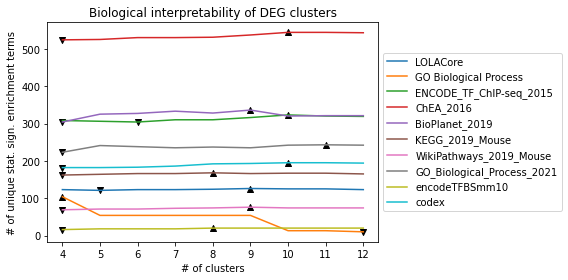

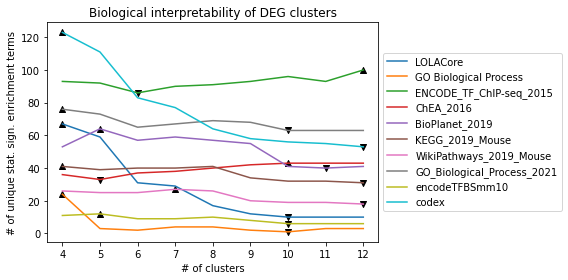

In [28]:
# make plots that show relationship between k and number of unique stat. sign. enrichment terms
plot_sum_df = pd.DataFrame(index=ks, columns=databases)
plot_unique_df = pd.DataFrame(index=ks, columns=databases)

for k in ks:
    for db in databases:
        tmp_results = pd.read_csv(os.path.join(data_dir, 'k_{}'.format(k), '0_summaries', "summary_{}_adjpvalues.csv".format(db)), index_col=0)
        plot_sum_df.loc[k,db]=tmp_results.shape[0]
        plot_unique_df.loc[k,db]=sum((tmp_results<0.05).sum(axis=1)==1)

# make sum plot
plot_sum_df= plot_sum_df.apply(pd.to_numeric)
plot_sum_df.plot.line(figsize=(8,4))
plt.scatter(plot_sum_df.idxmax(), plot_sum_df.max(), marker='^', color='k')
plt.scatter(plot_sum_df.idxmin(), plot_sum_df.min(), marker='v', color='k')
plt.xlabel('# of clusters')
plt.ylabel('# of unique stat. sign. enrichment terms')
plt.title('Biological interpretability of DEG clusters')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(
    fname=os.path.join(data_dir,"Biological_interpretability_sum.svg"),
    format="svg",
    dpi=300,
    bbox_inches="tight",
)
plt.show()

# make unique plot
plot_unique_df= plot_unique_df.apply(pd.to_numeric)
plot_unique_df.plot.line(figsize=(8,4))
plt.scatter(plot_unique_df.idxmax(), plot_unique_df.max(), marker='^', color='k')
plt.scatter(plot_unique_df.idxmin(), plot_unique_df.min(), marker='v', color='k')
plt.xlabel('# of clusters')
plt.ylabel('# of unique stat. sign. enrichment terms')
plt.title('Biological interpretability of DEG clusters')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(
    fname=os.path.join(data_dir,"Biological_interpretability_unique.svg"),
    format="svg",
    dpi=300,
    bbox_inches="tight",
)
plt.show()

# time-series clusters

In [30]:
# configs
annot_path = os.path.join(dir_data, 'time_series', 'timeseries_bedfiles', 'timeseries_enrichment_annotation.csv')
data_dir = os.path.join(dir_data, 'enrichment_analysis','time_series')

adj_pvalue=0.05
adj_pvalue_strict=0.01

# region-based enrichment results (LOLA or GREAT databases) need even more stringent adj.p-value cut-off
adj_pvalue_region=1.0E-4

ks = list(range(2,11))
ks

[2, 3, 4, 5, 6, 7, 8, 9, 10]

In [31]:
# load enrichment annotation
enrichment_annot = pd.read_csv(annot_path, index_col=0)
print(enrichment_annot.shape)
enrichment_annot.head()

(324, 3)


,regions_bed,background_name,background_bed
name,,,
C_albicans_k2_cluster_1,/nobackup/lab_bock/projects/bmdm-stim/results/...,BMDM,/nobackup/lab_bock/projects/bmdm-stim/results/...
C_albicans_k2_cluster_2,/nobackup/lab_bock/projects/bmdm-stim/results/...,BMDM,/nobackup/lab_bock/projects/bmdm-stim/results/...
C_albicans_k3_cluster_1,/nobackup/lab_bock/projects/bmdm-stim/results/...,BMDM,/nobackup/lab_bock/projects/bmdm-stim/results/...
C_albicans_k3_cluster_2,/nobackup/lab_bock/projects/bmdm-stim/results/...,BMDM,/nobackup/lab_bock/projects/bmdm-stim/results/...
C_albicans_k3_cluster_3,/nobackup/lab_bock/projects/bmdm-stim/results/...,BMDM,/nobackup/lab_bock/projects/bmdm-stim/results/...


In [ ]:
# summarize enrichment results per treatment & k
for treatment in treatments:
    for k in ks:
        region_list_names = [region_list for region_list in list(enrichment_annot.index) if '{}_k{}_'.format(treatment, k) in region_list]
        summarize_enrichment(region_list_names=region_list_names, 
                             data_dir=data_dir, 
                             result_dir = os.path.join(data_dir, '{}_k{}_'.format(treatment, k)),
                             top_n=10)

dict_keys(['ENCODE_TF_ChIP-seq_2015', 'ChEA_2016', 'encodeTFBSmm10', 'codex'])
ENCODE_TF_ChIP-seq_2015 145
ChEA_2016 467
encodeTFBSmm10 13
codex 140
2
2
2
2
dict_keys(['ENCODE_TF_ChIP-seq_2015', 'ChEA_2016', 'encodeTFBSmm10', 'codex'])
ENCODE_TF_ChIP-seq_2015 141
ChEA_2016 469
encodeTFBSmm10 15
codex 159
3
3
3
3
dict_keys(['ENCODE_TF_ChIP-seq_2015', 'ChEA_2016', 'encodeTFBSmm10', 'codex'])
ENCODE_TF_ChIP-seq_2015 123
ChEA_2016 472
encodeTFBSmm10 17
codex 163
4
4
4
4
dict_keys(['ENCODE_TF_ChIP-seq_2015', 'ChEA_2016', 'encodeTFBSmm10', 'codex'])
ENCODE_TF_ChIP-seq_2015 97
ChEA_2016 468
encodeTFBSmm10 14
codex 160
5
5
5
5
dict_keys(['ENCODE_TF_ChIP-seq_2015', 'ChEA_2016', 'encodeTFBSmm10', 'codex'])
ENCODE_TF_ChIP-seq_2015 100
ChEA_2016 466
encodeTFBSmm10 15
codex 162
6
6
6
6
dict_keys(['ENCODE_TF_ChIP-seq_2015', 'ChEA_2016', 'encodeTFBSmm10', 'codex'])
ENCODE_TF_ChIP-seq_2015 113
ChEA_2016 454
encodeTFBSmm10 17
codex 166
7
7
7
7
dict_keys(['ENCODE_TF_ChIP-seq_2015', 'ChEA_2016', 'encodeT

In [ ]:
# make plots that show relationship between k and number of unique stat. sign. enrichment terms
for treatment in treatments:
    plot_sum_df = pd.DataFrame(index=ks, columns=databases)
    plot_unique_df = pd.DataFrame(index=ks, columns=databases)
    for k in ks:
        for db in databases:
            tmp_results = pd.read_csv(os.path.join(data_dir,"{}_k{}_".format(treatment, k),"0_summaries", "summary_{}_adjpvalues.csv".format(db)), index_col=0)
            plot_sum_df.loc[k,db]=tmp_results.shape[0]
            plot_unique_df.loc[k,db]=sum((tmp_results<0.05).sum(axis=1)==1)
    
    # make sum plot
    plot_sum_df= plot_sum_df.apply(pd.to_numeric)
    plot_sum_df.plot.line(figsize=(8,4))
    plt.scatter(plot_sum_df.idxmax(), plot_sum_df.max(), marker='^', color='k')
    plt.scatter(plot_sum_df.idxmin(), plot_sum_df.min(), marker='v', color='k')
    plt.xlabel('# of clusters')
    plt.ylabel('# of unique stat. sign. enrichment terms')
    plt.title('Biological interpretability of {} time-series clusters'.format(treatment))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.savefig(
        fname=os.path.join(data_dir,"Biological_interpretability_sum_"+treatment+".svg"),
        format="svg",
        dpi=300,
        bbox_inches="tight",
    )
    plt.show()
    
    # make unique plot
    plot_unique_df= plot_unique_df.apply(pd.to_numeric)
    plot_unique_df.plot.line(figsize=(8,4))
    plt.scatter(plot_unique_df.idxmax(), plot_unique_df.max(), marker='^', color='k')
    plt.scatter(plot_unique_df.idxmin(), plot_unique_df.min(), marker='v', color='k')
    plt.xlabel('# of clusters')
    plt.ylabel('# of unique stat. sign. enrichment terms')
    plt.title('Biological interpretability of {} time-series clusters'.format(treatment))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.savefig(
        fname=os.path.join(data_dir,"Biological_interpretability_unique_"+treatment+".svg"),
        format="svg",
        dpi=300,
        bbox_inches="tight",
    )
    plt.show()